In [149]:
import numpy as np
import matplotlib.pyplot as pyplot
from scipy import optimize
from scipy.io import loadmat
import csv

In [150]:
# Configurando parametros necesario
input_layer_size  = 784     # Ingresar imágenes de dígitos de 28x28
hidden_layer_size = 40      # 25 unidades ocultas
num_labels = 26             # 10 etiquetas, de 0 a 9

data = loadmat('emnist-letters.mat')
# mostramos las llaves de dataset
print(data.keys())
data = data['dataset']

dict_keys(['__header__', '__version__', '__globals__', 'dataset'])


In [151]:
# sacamos los datos de entrenamiendo
datos_entrenamiento = data['train'][0, 0]
# sacamos los datos de prueba
datos_pruebas = data['test'][0, 0]

In [152]:
# cargamos los datos a usar tanto en X como Y de entrenamiento
X_train = datos_entrenamiento['images'][0][0]
y_train = datos_entrenamiento['labels'][0][0].ravel()
# cargamos los datos a usar tanto en X como Y de pruebas
X_test = datos_pruebas['images'][0][0]
y_test = datos_pruebas['labels'][0][0].ravel()

In [153]:
print('-------Datos de entrenamiento-------')
print('X shape: ',X_train.shape)
y_train[y_train == 26] = 0
print('y shape: ',y_train.shape)
print('y clases: ',set(y_train))
print('-------Datos de test-------')
print('X shape: ',X_test.shape)
y_test[y_test == 26] = 0
print('y shape: ',y_test.shape)
print('y clases: ',set(y_test))

-------Datos de entrenamiento-------
X shape:  (124800, 784)
y shape:  (124800,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
-------Datos de test-------
X shape:  (20800, 784)
y shape:  (20800,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


In [154]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [155]:
# mi X_train sea valores de 0 a 1 crea una funcion
def normalizar(X):
    # normalizamos los datos
    X = X / 255
    return X

In [156]:
# normalizamos las X's de entrenamiento
X_train_norm = normalizar(X_train)
# normalizamos las X's de prueba
X_test_norm = normalizar(X_test)

In [157]:
# sacar el maximo valor de X_train_norm
max_value = np.max(X_train_norm)
# sacar el minimo valor de X_train_norm
min_value = np.min(X_train_norm)
print('Valor maximo de X_train_norm: ',max_value)
print('Valor minimo de X_train_norm: ',min_value)

Valor maximo de X_train_norm:  1.0
Valor minimo de X_train_norm:  0.0


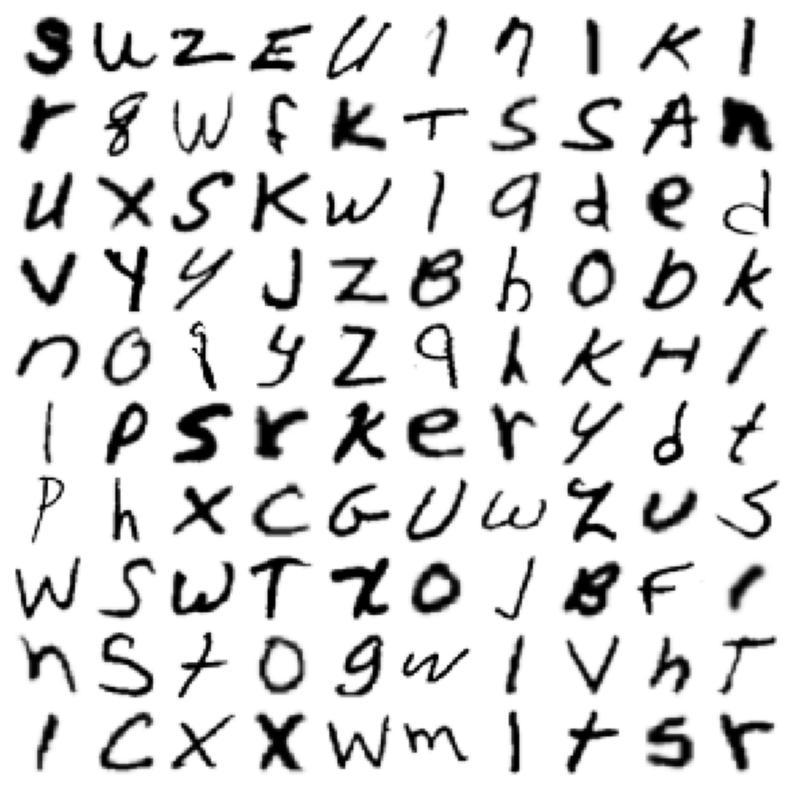

In [158]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
m = y_train.size
rand_indices = np.random.choice(m, 100, replace=False)
sel = X_train[rand_indices, :]

displayData(sel)

In [159]:

def checkNNGradients(nnCostFunction, lambda_=0.0):
    """
    Verifica los gradientes calculados por backpropagation en una red neuronal.

    Parameters:
    - nnCostFunction: Función de costo de la red neuronal.
    - lambda_: Parámetro de regularización (por defecto es 0.0).

    Returns:
    - diff: Diferencia relativa entre los gradientes numéricos y los gradientes aproximados por backpropagation.
    """

    # Obtén los gradientes por backpropagation
    cost, grad = nnCostFunction()

    # Inicializa los gradientes numéricos
    numgrad = np.zeros_like(grad)

    # Valor pequeño para la aproximación numérica
    epsilon = 1e-4

    # Itera sobre cada parámetro en la red neuronal
    for i in range(len(grad)):
        # Aproximación numérica del gradiente
        theta_plus = np.copy(nnCostFunction.theta)
        theta_plus[i] += epsilon
        theta_minus = np.copy(nnCostFunction.theta)
        theta_minus[i] -= epsilon

        # Cálculo del costo para los parámetros theta_plus y theta_minus
        cost_plus = nnCostFunction(theta_plus, lambda_)
        cost_minus = nnCostFunction(theta_minus, lambda_)

        # Aproximación numérica del gradiente
        numgrad[i] = (cost_plus - cost_minus) / (2 * epsilon)

    # Calcula la diferencia relativa entre los gradientes numéricos y los gradientes por backpropagation
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)

    return diff


def sigmoid(z):
    """
    Calcula la función sigmoide de un número o una matriz.

    Parameters:
    - z: Número o matriz.

    Returns:
    - result: Resultado de aplicar la función sigmoide a z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [160]:
def sigmoidGradient(z):
    """
    Calcula el gradiente de la función sigmoidea evaluada en z.
    Esto debería funcionar independientemente de si z es una matriz o un vector. 
    En particular, si z es un vector o una matriz, debe devolver el gradiente para cada elemento.
    
    Nota
    Hemos proporcionado una implementación de la función sigmoidea
    en el archivo `utils.py` que acompaña a esta tarea.
    """

    g = np.zeros(z.shape)

    g = sigmoid(z) * (1 - sigmoid(z))

    return g

In [161]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size
         
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(Theta2.T))
    
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    temp1 = Theta1
    temp2 = Theta2
    
    # Agregar el termino de regularización
    
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
    epsilon = 1e-8
    J = (-1 / m) * np.sum((np.log(a3+epsilon) * y_matrix) + np.log(1 - a3+epsilon) * (1 - y_matrix)) + reg_term
    
    # Backpropogation
    
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    
    # Agregar regularización al gradiente

    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

In [162]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Inicializar aleatoriamente los pesos de una capa en una red neuronal.
    
     Parámetros
     ----------
     L_in : int
         Número de conexiones entrantes.
    
     L_out: int
         Número de conexiones salientes.
    
     epsilon_init: flotante, opcional
         Rango de valores que puede tomar el peso de un uniforme
         distribución.
    
     Devoluciones
     -------
     W : array_like
         El peso inicializado a valores aleatorios. Tenga en cuenta que W debe
         establecerse en una matriz de tamaño (L_out, 1 + L_in) como
         la primera columna de W maneja los términos de "sesgo".
    """
        

    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [163]:
print('Inicialización de parámetros de redes neuronales...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

print('initial_Theta1 shape: ',initial_Theta1.shape)
print('initial_Theta2 shape: ',initial_Theta2.shape)

# Desenrrollr parametros
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Inicialización de parámetros de redes neuronales...
initial_Theta1 shape:  (40, 785)
initial_Theta2 shape:  (26, 41)


In [164]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [165]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxfun': 1000}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X_train_norm, y_train, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [169]:
import csv
def escribir_thetas_a_csv(matriz, nombre_archivo):
    with open(nombre_archivo, mode='w', newline='') as archivo_csv:
        writer = csv.writer(archivo_csv, delimiter=',')
        for fila in matriz:
            writer.writerow(fila)

In [183]:
escribir_thetas_a_csv(Theta1, 'Theta1_emnist_26.csv')
escribir_thetas_a_csv(Theta2, 'Theta2_emnist_26.csv')
print('Theta1', Theta1.shape)
print('Theta2', Theta2.shape)
print(Theta1[0, :])

Theta1 (40, 785)
Theta2 (26, 41)
[ 2.62337068e+00 -1.95852296e-02  2.18378500e-02 -3.74276459e-04
 -4.70298403e-04  9.33546284e-02  2.50886044e-01 -1.19412362e-01
 -2.72344408e-01 -3.22805464e-01  1.10358468e-02  7.20983097e-02
  1.97185042e-01  1.89131623e-01  4.07187824e-02 -1.35956943e-01
 -1.48980506e-01 -1.70684228e-01 -1.08530456e-01  6.74348806e-02
  1.89111232e-01 -1.32868452e-01 -1.54955424e-01 -2.98413706e-02
 -1.08248849e-02 -1.70132899e-02  8.06043299e-03 -1.20775556e-02
 -2.17571228e-02 -1.21068452e-02 -1.71361093e-02  5.87741485e-03
  8.46488837e-02  2.14996191e-01  1.03389176e-01 -1.99545651e-01
  1.73859546e-01  4.58412126e-01  1.51407788e-01 -2.83138611e-01
 -2.61184625e-03 -5.81787646e-02 -3.62197793e-04 -5.14568844e-01
 -5.11767280e-01 -8.40957075e-01 -9.59622018e-01  1.41539949e-01
  1.19184819e-02 -4.99133044e-01 -4.45836004e-01 -2.33669534e-01
 -6.95974812e-02  1.35111425e-01  1.95696717e-01  6.89587022e-03
 -1.99815333e-03 -2.14620211e-02 -1.70609336e-03  2.35028

In [176]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.

    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)

    Theta2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)

    X : array_like
        The image inputs having shape (number of examples x image dimensions).

    Return
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.

    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.

    """
    # Asegúrar que la entrada tenga dos dimensiones
    if X.ndim == 1:
        X = X[None]  # promover a dos dimensiones

    # Variables utiles
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros(X.shape[0])

    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    p = np.argmax(sigmoid(a2.dot(Theta2.T)), axis = 1)

    return p

In [172]:
train_pred = predict(Theta1, Theta2, X_train_norm)
print('Precisión del conjunto de entrenamiento: {:.1f}%'.format(np.mean(train_pred == y_train) * 100))
test_pred = predict(Theta1, Theta2, X_test_norm)
print('Precisión del conjunto de test: {:.1f}%'.format(np.mean(test_pred == y_test) * 100))

Precisión del conjunto de entrenamiento: 88.5%
Precisión del conjunto de test: 84.9%


IndexError: index 40 is out of bounds for axis 0 with size 40

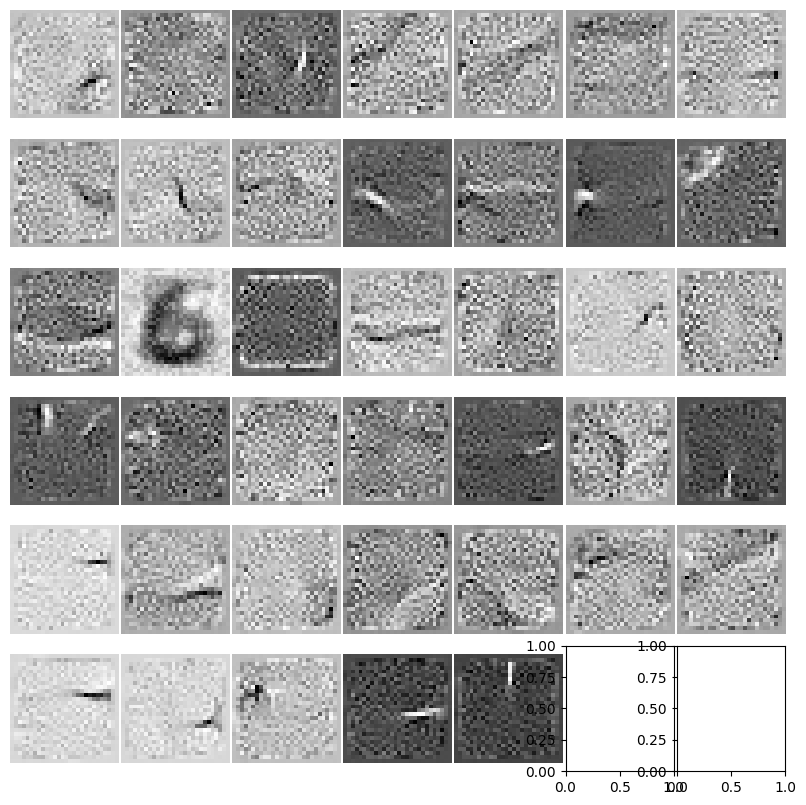

In [187]:
displayData(Theta1[:, 1:])

In [192]:
# hazme una funcion que recibiendo un numero me devuelva la letra en esa posicion
def numero_a_letra(numero):
    # en una lista de letras, la posicion del numero es la letra
    letras = ['Z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W','X', 'Y']
    return letras[numero]

------Prediccion del modelo MLP------
Clase: 19
Letra:  S
------Datos reales------
Clase:  19
Letra:  S


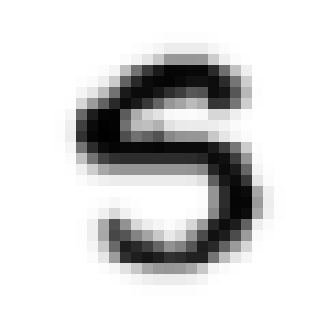

In [197]:
fila_test = 15023
displayData(X_test[fila_test, :], figsize=(4, 4))
pred = predict(Theta1, Theta2, X_test_norm[fila_test, :])
print('------Prediccion del modelo MLP------')
print('Clase: {}'.format(*pred))
print('Letra: ', numero_a_letra(*pred))
print('------Datos reales------')
print('Clase: ', y_test[fila_test])
print('Letra: ', numero_a_letra(y_test[fila_test]))

------Prediccion del modelo MLP------
Clase: 8
Letra:  H
------Datos reales------
Clase:  8
Letra:  H


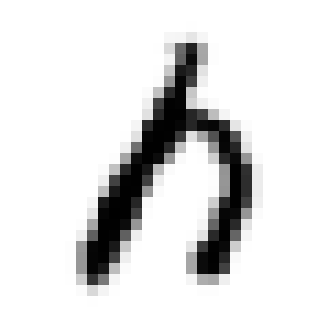

In [198]:
displayData(X_train[fila_test, :], figsize=(4, 4))
pred = predict(Theta1, Theta2, X_train_norm[fila_test, :])
print('------Prediccion del modelo MLP------')
print('Clase: {}'.format(*pred))
print('Letra: ', numero_a_letra(*pred))
print('------Datos reales------')
print('Clase: ', y_train[fila_test])
print('Letra: ', numero_a_letra(y_train[fila_test]))